# A Road to Frictionless Urban Data Science: `osmnx` & `cenpy`. 

With better geospatial computation tools than ever, urban data science is becoming easier and more accessbile. But, one of the most difficult parts of *Doing* data science is getting clean, useful data in a format that you can actually analyze. Fortunately, a variety of new packages in Python can help with this. We'll look at two here:

## OSMNX

OSMNX, (styled `osmnx`), is a well-used package to examine Open Streetmap data from python. A good overview of the core concepts & ideas comes from [@gboeing](https://geoffboeing.com/2018/03/osmnx-features-roundup/), the lead author and maintainer of the package. Here, we'll use it to extract the street network of Austin, TX. 


## Cenpy

CenPy (pronounced `sen-pie`) is a a python package for interacting with the US Census Bureau's Data Products, hosted at [`api.census.gov`](https://api.census.gov). The Census exposes *a ton* of data products for people to use. Cenpy itself provides 2 "levels" of access. 

### Census `products`

Most users simply want to get into the census, retrieve data, and then map, plot, analyze, or model that data. For this, `cenpy` wraps the main "products" that users may want to access: the American Community Survey & 2010 Decennial Census. These are desgined to interface directly with the US Census Bureau's data APIs, get both the geographies & data from the US Census, and return that to the user, ready to plot. We'll cover this API here. 

### Building Blocks of `cenpy.products`

For those interested, `cenpy` also has a lower-level interface designed to directly interact with US Census data products through their two constituent parts: the *data product* from https://api.census.gov, and the *geography product*, from the US Census's ESRI MapServer. This is intended for developers to build new `products` or to interface directly with the API as they wish. This is pretty straightforward to use, but requires a bit more technical knowledge to make *just work*, so if you simply need US Census or ACS data, focus on the `product` API. 

# Using the Packages

To use packages in python, you must first `import` the package. Below, we import three packages:

- `cenpy`
- `osmnx`
- `matplotlib.pyplot`

In [2]:
import cenpy
import osmnx
import matplotlib.pyplot as plt
%matplotlib inline

`osmnx` and `cenpy.products` work using a *place*-oriented API. This means that users specify a place name, like `Columbus, OH` or `Kansas City, MO-KS`, or `California`, and the package parses this name and grabs the relevant data. `osmnx` uses the Open Street Map service and `cenpy` uses the Us Census Bureau's service, so they can sometimes disagree slightly, *especially* when considering older census products. Regardless, to grab the US census data using `cenpy`, you pass the place name and the columns of the Census product you wish to extract. Below, we'll grab two columns from the American Community Survey: Total population (`B02001_001E`) and count of African American persons (`B02001_003E`). We'll grab this from Austin, TX:

In [3]:
aus_data = cenpy.products.ACS().from_place('Austin, TX', 
                                           variables=['B02001_001E', 'B02001_003E'])

/home/lw17329/Dropbox/dev/cenpy/cenpy/geoparser.py:214: UserWarning: Shape is invalid: 
Ring Self-intersection[-10884881.1468 3554135.7868]
  tell_user('Shape is invalid: \n{}'.format(vexplain))


Matched: Austin, TX to Austin city within layer Incorporated Places


When this runs, `cenpy` does a few things:
1. it asks the census for all the relevant US Census Tracts that fall within Austin, TX
2. it parses the shapes of Census tracts to make sure they're valid
3. it parses the data from the Census to ensure it's valid

Above, you may see a warning that the Austin, TX shape is *invalid*! This is `cenpy` running validation on the data. This problem can be fixed, but does not immediately affect analyses. 

Likewise, OSMNX has a place-oriented API. To grab the street network from Austin, we can run a similar query:

In [4]:
aus_graph = osmnx.graph_from_place('Austin, TX')

However, the two pcakages default representations are quite different. `osmnx` focuses on the `networkx` package for its core representation (hence, `osm` for Open Streetmap and `nx` for NetworkX):

In [5]:
aus_graph

In contrast `cenpy` uses `pandas` (and, specifically, `geopandas`) to express the demographics and geography of US Census data. These packages provide dataframes, like spreadsheets, which can be used to analyze data in Python. Below, each road contains the shape of *one* US Census tract (the geometry used by default in by `cenpy`), and the columns provide descriptive information about the tract. 

In [6]:
aus_data.head()

,GEOID,geometry,B02001_001E,B02001_003E,state,county,tract
0,48453002003,"POLYGON ((-10885870.78 3531403.57, -10885801.9...",4061.0,238.0,48,453,002003
1,48453001307,"POLYGON ((-10884436.87 3532796.35, -10884432.4...",3775.0,316.0,48,453,001307
2,48453001200,"POLYGON ((-10883885.28 3538771.92, -10883869.8...",4972.0,70.0,48,453,001200
3,48453002419,"POLYGON ((-10883764.28 3528065.19, -10883691.4...",4773.0,749.0,48,453,002419
4,48453001401,"POLYGON ((-10881722.01 3534812.03, -10881693.0...",3360.0,80.0,48,453,001401


Fortunately, you can convert the `networkx` objects that `osmnx` focuses on into `pandas` dataframes, so that both `cenpy` and `osmnx` match in their representation. This makes it very easy to work with OSM data alongside of census data. 

To convert the OSM data into a `pandas` dataframe, we must do two things.

First, we need to use the `osmnx.graph_to_gdfs` to convert the graph to `GeoDataFrames`, which are like a standard `pandas.DataFrame`, but with additional geographic information on the shape of each road. The `graph_to_gdfs` actually produces *two* dataframes: one full of roads and one full of *intersections*. We'll separate the two below:

In [7]:
aus_nodes, aus_streets  = osmnx.graph_to_gdfs(aus_graph)

Now, the `aus_streets` dataframe looks like the `aus_data` dataframe, where each row is a street, and columns contain some information about the street:

In [9]:
aus_streets.head()

,access,area,bridge,geometry,highway,junction,key,landuse,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
0,NaN,NaN,NaN,"LINESTRING (-97.7963408 30.1596324, -97.796750...",service,NaN,0,NaN,NaN,69.530,NaN,NaN,False,191679752,NaN,NaN,NaN,5532286976,2022679877,NaN
1,NaN,NaN,NaN,"LINESTRING (-97.7963408 30.1596324, -97.796320...",service,NaN,0,NaN,NaN,17.599,NaN,NaN,False,191679752,NaN,NaN,NaN,5532286976,5532286980,NaN
2,NaN,NaN,NaN,"LINESTRING (-97.7963408 30.1596324, -97.795931...",service,NaN,1,NaN,NaN,126.129,NaN,NaN,False,576925636,NaN,NaN,NaN,5532286976,5532286980,NaN
3,NaN,NaN,NaN,"LINESTRING (-97.7963036 30.1594804, -97.796320...",service,NaN,0,NaN,NaN,17.599,NaN,NaN,False,191679752,NaN,NaN,NaN,5532286980,5532286976,NaN
4,NaN,NaN,NaN,"LINESTRING (-97.7963036 30.1594804, -97.796111...",service,NaN,1,NaN,NaN,126.129,NaN,NaN,False,576925636,NaN,NaN,NaN,5532286980,5532286976,NaN


The last bit of data processing that is needed to make the two datasets fully comport within one another is to set their *coordinate reference systems* to ensure that they align. The US Census provides geographical data in Web Mercator projection (likely due to the fact that it serves many webmapping applications in the US Government), whereas the Open Streetmap project serves data in raw latitude/longitude by default. 

To convert data between coordinate reference systems, we can use the `to_crs` method of `GeoDataFrames`. This changes the coordinate reference system for the dataframe. To convert one dataframe into the coordiante reference system of another, it's often enough to provide the coordinate reference of the *target* dataframe to the `to_crs` function:

In [14]:
aus_data = aus_data.to_crs(aus_streets.crs)

Now, the two dataframes have the same coordinate reference system:

In [15]:
aus_data.crs

'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

In [16]:
aus_streets.crs

'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

Now, we can make maps using the data, or can conduct analyses using the streets & demographics of Austin, TX:

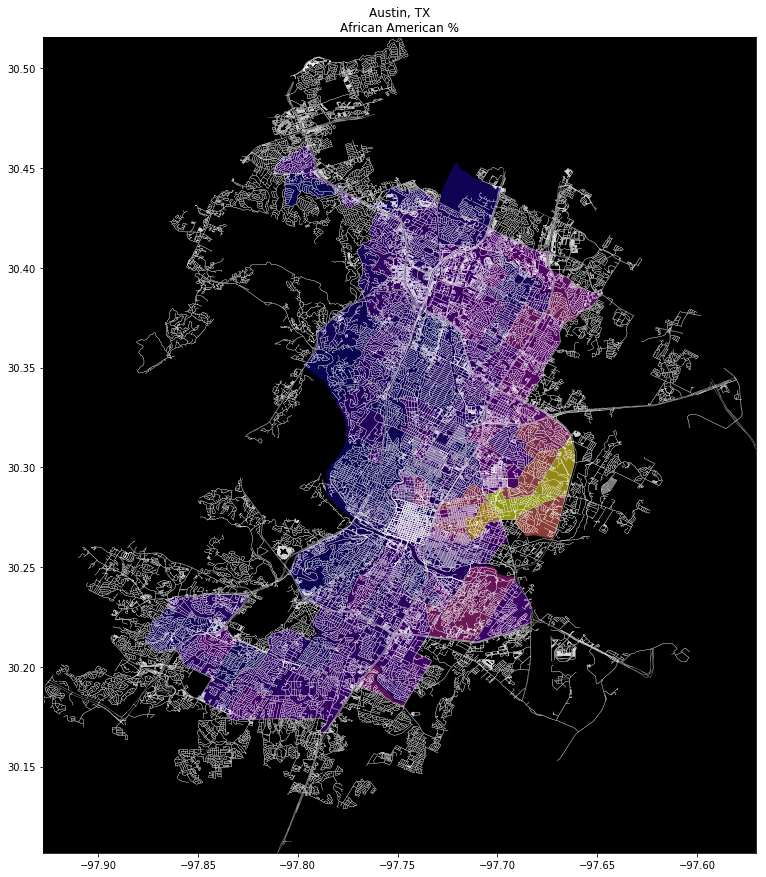

In [19]:
f,ax = plt.subplots(1,1, figsize=(15,15))
aus_data.eval('pct_afam = B02001_003E / B02001_001E')\
        .plot('pct_afam', cmap='plasma', alpha=.6, ax=ax, linewidth=.25, edgecolor='k')
aus_streets.plot(linewidth=.25, ax=ax, color='w')
ax.axis(aus_streets.total_bounds[[0,2,1,3]])
ax.set_title('Austin, TX\nAfrican American %')
ax.set_facecolor('k')

This means that urban data science in Python has never been easier! So much data is at your fingertips, `from_place` away. Both packages can be installed from `conda-forge`, the community-driven package repository in Anaconda, the scientific python distribution. Check out other examples of using [`cenpy`](https://cenpy-devs.github.io/cenpy) and [`osmnx`](https://osmnx.readthedocs.io/en/stable/) from their respective websites